# <div style="text-align: center"> <font size=+5> <ins>PREDICT ANSWERS from INDICATORS</ins> </font> </div>
___

In [3]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi' : 300,
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [61]:
data_issp = pd.read_pickle("Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,("Questions", slice(None))].droplevel("Variable Type", axis=1)
data_issp["Weight"] = pd.read_pickle("Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,("Respondent Data", "Weight")]
data_issp.columns.name = None


def conv_answers(label):
    convDict = {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes" : 1,
        "No" : -1,

        'Extremely dangerous': 2,
        'Very dangerous': 1,
        'Somewhat dangerous': 0,
        'Not very dangerous': -1,
        'Not dangerous at all': -2,

        "Always" : 3,
        "Often" : 2,
        "Sometimes" : 1,
        "Never" : 0,

        'Very willing': 2,
        'Fairly willing': 1,
        'Neither willing nor unwilling': 0,
        'Fairly unwilling': -1,
        'Very unwilling': -2
    }
    return convDict[label] if label in convDict else label

data_issp = data_issp.drop(columns=["Highest priority for country", "Second highest priority for country"]).map(conv_answers).astype(float)
data_issp = data_issp.mul(data_issp["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data_issp["Weight"].groupby(["Year", "Country"]).sum(), axis="index").drop(columns="Weight")


indicators_dict = {(ind[:-7], year) : pd.read_pickle(f"Processed_Data/indicators/{ind}").loc[:,[year]].rename(columns={year : ind[:-7]}) for ind in os.listdir("Processed_Data/indicators") if ind[-7:] == ".pickle" for year in [1993,2000,2010,2020]}

In [62]:
def fit_lasso(yX, alpha):
    model = Lasso(alpha)
    model.fit(yX.iloc[:,1:], yX.iloc[:,0])
    return {"alpha" : alpha, "loss" : 1-model.score(yX.iloc[:,1:], yX.iloc[:,0]), "coefficients" : model.coef_}

def get_main_indicators(question, year, indicators_names=None, n_coef=3, tol=0.1):
    # indicators --> filename for indicators to choose from, `None` for all .pickle files in "Processed_Data/indicators"
    # n_coef     --> how many "most relevant" indicators to select
    # tol        --> will still select more indicators if model error is more than `best_error + tol * (worse - best)`
    
    if indicators_names == None:
        indicators = [ind for key, ind in indicators_dict.items() if key[1] == year]
    else:
        indicators = [indicators_dict[(ind, year)] for ind in indicators_names]

    answers = data_issp.loc[(year, slice(None)),:].reset_index().set_index("Country").loc[:,question]
    yX = pd.concat([answers, *indicators], axis=1, join="inner").dropna()
    yX.iloc[:,:] = StandardScaler().fit_transform(yX.to_numpy())

    res = pd.DataFrame([fit_lasso(yX, alpha) for alpha in np.logspace(-6,0,250)])
    
    for idx in res.index[::-1]:
        if sum(np.vectorize(lambda x: x != 0.)(res.loc[idx,"coefficients"])) > n_coef and (res.loc[idx, "loss"] - res["loss"].min())/(res["loss"].max() - res["loss"].min()) < tol:
            best = res.loc[idx+1,:].copy()
            best["indicators"] = [ind for i, ind in enumerate(yX.columns[1:]) if best["coefficients"][i] != 0]
            break
    return best



def plot_indicators(question, year, indicators_names=None):

    if indicators_names == None:
        indicators = [ind for key, ind in indicators_dict.items() if key[1] == year]
    else:
        indicators = [indicators_dict[(ind, year)] for ind in indicators_names]

    answers = data_issp.loc[(year, slice(None)),:].reset_index().set_index("Country").loc[:,question]
    yX = pd.concat([answers, *indicators], axis=1, join="inner").dropna()
    yX.iloc[:,:] = StandardScaler().fit_transform(yX.to_numpy())

    res = pd.DataFrame([fit_lasso(yX, alpha) for alpha in np.logspace(-6,0,250)])
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6.4*2,4.8), gridspec_kw={"width_ratios" : (5,95)}, sharey=True)
    fig.subplots_adjust(wspace=0)
    fig.suptitle(f"Most important indicators to predict '{question}' in {year}", fontsize=20)
    data = np.stack(res["coefficients"].to_numpy())
    sns.heatmap([[np.log(l)] for l in res["loss"]], ax=ax1, cbar=False)
    sns.heatmap(data, cmap="bwr", center=0, ax=ax2)
    ax2.set_title("Coefficients in LASSO regression")
    ax2.set_xticklabels(yX.iloc[:,1:].columns, rotation=30, horizontalalignment="right", fontsize=8)
    ax2.set_xlabel("Indicator")
    ax1.set_yticks(res.index[::50])
    ax1.set_yticklabels([f"{l:.0e}" for l in res.loc[::50,"alpha"]], rotation=30, horizontalalignment="right", verticalalignment="top", fontsize=8)
    ax1.tick_params(axis="y", pad=0)
    ax1.set_ylabel("L1 regularization hyperparameter")
    ax1.set_title("Model error")
    ax1.set_xticks([])
    
    plt.tight_layout()

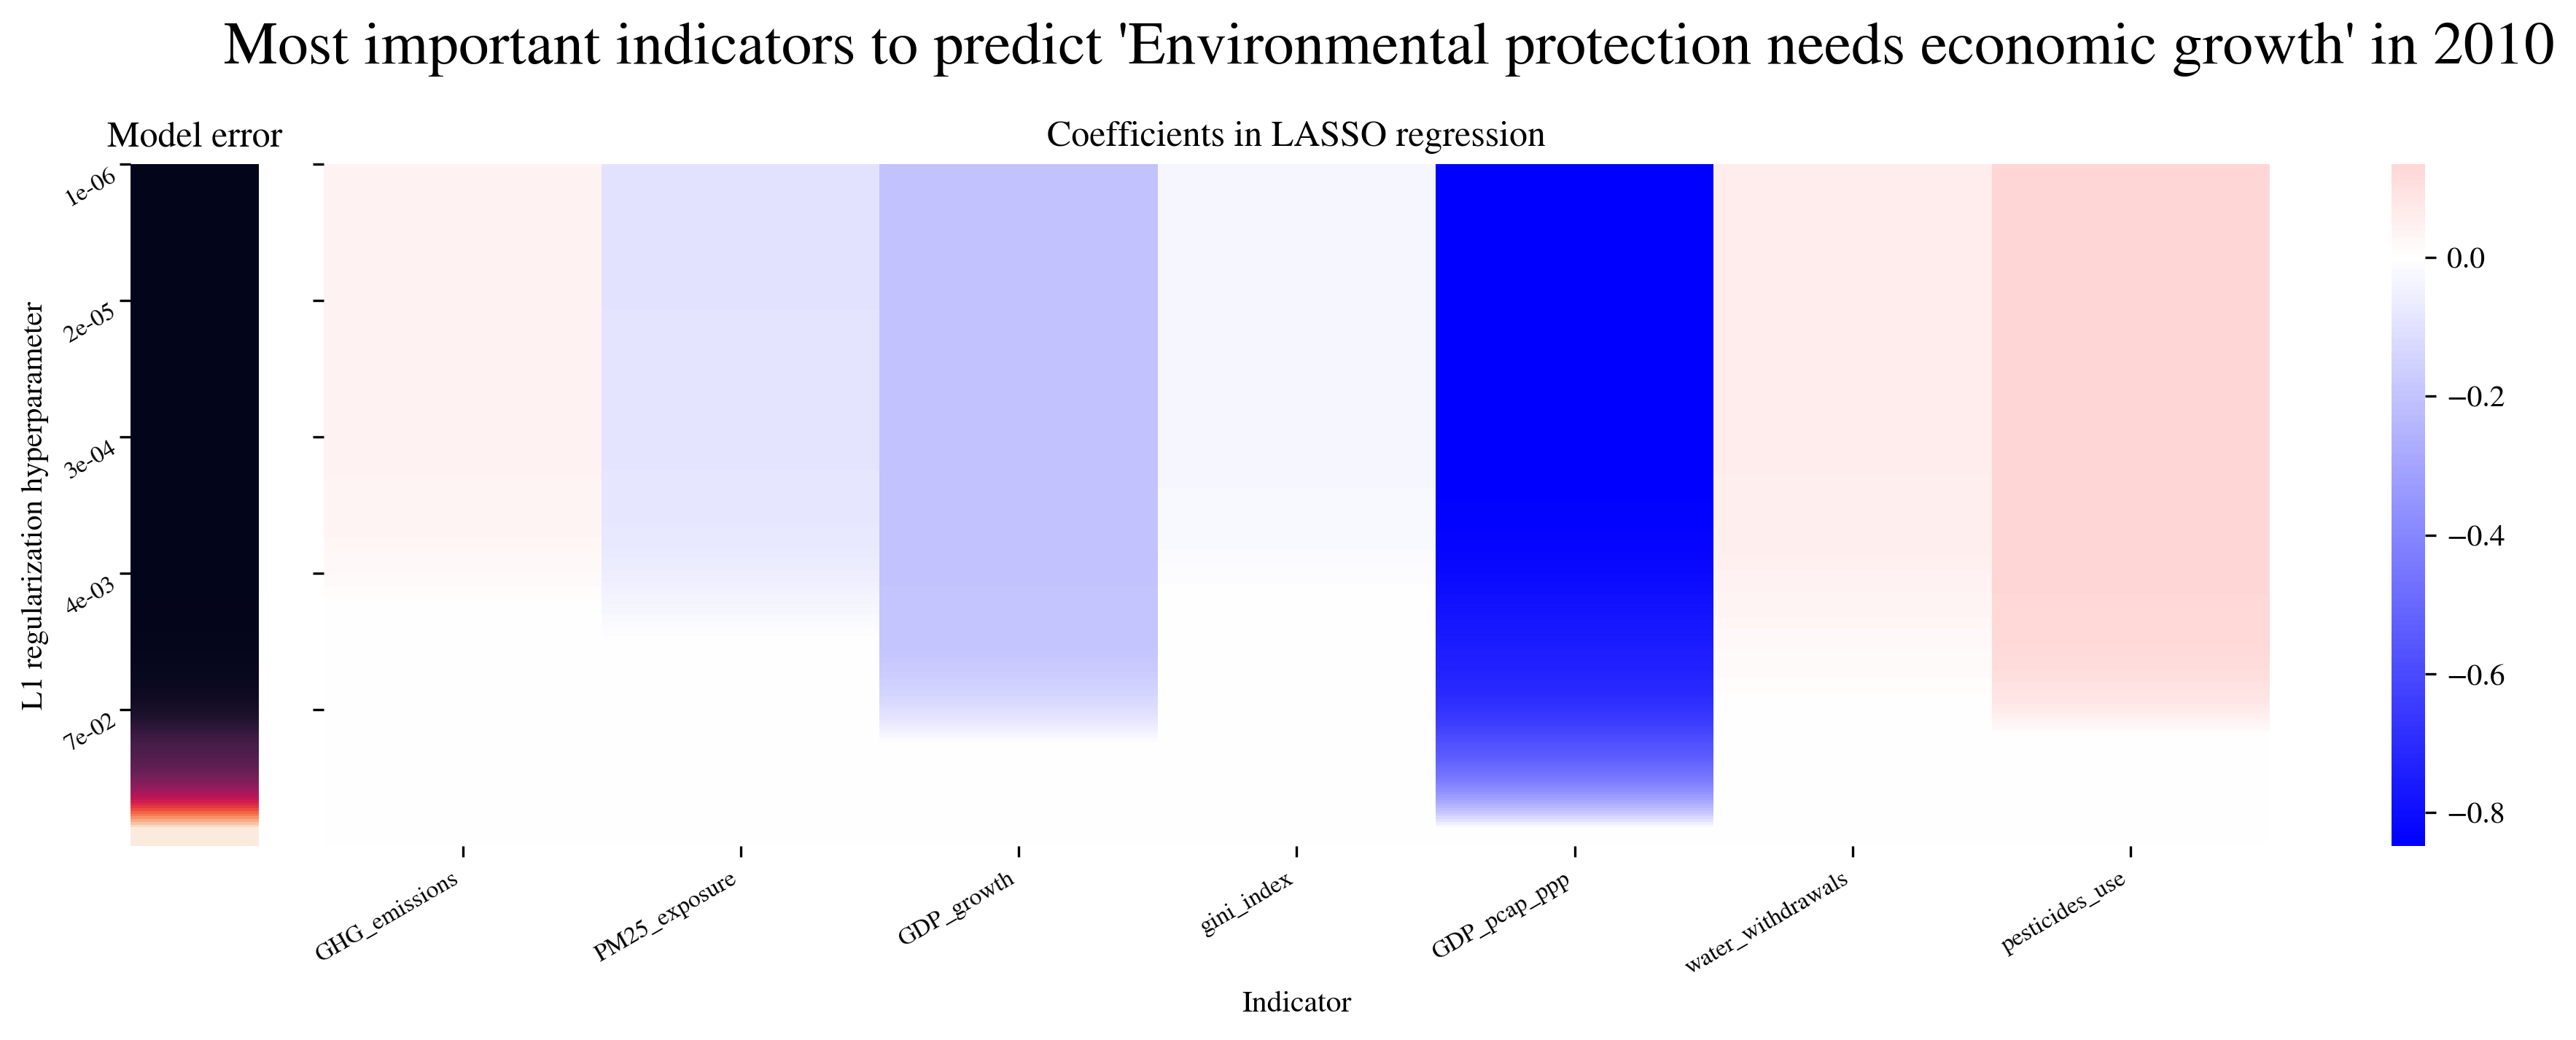

In [63]:
question = "Environmental protection needs economic growth"
year = 2010

indicators=["GHG_emissions", "PM25_exposure", "GDP_growth", "gini_index", "GDP_pcap_ppp", "water_withdrawals", "pesticides_use"]
plot_indicators(question, year, indicators)

In [64]:
indicators=["GHG_emissions", "PM25_exposure", "GDP_growth", "gini_index", "GDP_pcap_ppp", "water_withdrawals", "pesticides_use"]
predictive_indicators = pd.DataFrame(columns=indicators).T

for year, question in ((y,q) for q in data_issp.columns for y in [1993,2000,2010,2020]):
    predictive_indicators[(question, year)] = get_main_indicators(question, year, indicators, n_coef=3, tol=1)["coefficients"]
predictive_indicators = predictive_indicators.T
predictive_indicators.index = pd.MultiIndex.from_tuples(predictive_indicators.index, names=["Question", "Year"])
predictive_indicators.columns.name = "Indicators"
#predictive_indicators.to_pickle("./Saved_variables/predictive_indicators.pickle")

In [6]:
predictive_indicators = pd.read_pickle("./Saved_variables/predictive_indicators.pickle")

In [ ]:
clm = sns.clustermap(predictive_indicators.groupby("Question").mean(), dendrogram_ratio=0.1, figsize=(6.4*2,4.8*2), cbar_pos=(1,0.1,0.02,.8), cmap="bwr", center=0, yticklabels=1)
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
#clm.tick_params(labelsize=5)

In [71]:
data = predictive_indicators.groupby("Question").mean()

def cluster_dataframe(data, cmap="bwr", method="ward", show=False, row_cluster=True, col_cluster=True):
    from scipy.cluster.hierarchy import linkage, dendrogram

    if row_cluster:
        row_linkage = linkage(data, method=method, optimal_ordering=True)
        row_order = dendrogram(row_linkage, no_plot=True)['leaves']
    else:
        row_order = slice(None)

    if col_cluster:
        col_linkage = linkage(data.T, method=method,  optimal_ordering=True)
        col_order = dendrogram(col_linkage, no_plot=True)['leaves']

    else:
        col_order = slice(None)
        
    abs_max = data.abs().max(axis=None)

    if show:
        display(data.iloc[row_order, col_order].style.background_gradient(cmap=cmap, axis=None, vmin=-abs_max, vmax=abs_max))
    else:
        return data.iloc[row_order, col_order]

cluster_dataframe(data, show=True)

Indicators,GDP_pcap_ppp,GHG_emissions,water_withdrawals,pesticides_use,GDP_growth,PM25_exposure,gini_index
Question,,,,,,,
Sort glass for recycling,0.442066,0.000000,0.020327,0.098677,0.066691,0.000000,-0.258892
"In the last five years, signed a petition",0.514202,-0.008891,-0.023134,0.017840,-0.001766,-0.095526,0.000000
"In the last five years, given money",0.719296,0.000000,-0.031390,0.011175,0.044995,0.037538,0.000000
Willingness to Make Trade-Offs for Environment (Cut your standard of living),0.462566,-0.043494,0.000521,-0.004568,0.130088,0.142586,-0.009935
Willingness to Make Trade-Offs for Environment (Pay much higher taxes),0.314461,0.006846,0.087411,0.131232,0.085372,0.117956,0.068549
Member of a group to preserve environment,0.411549,0.000000,0.025514,0.112853,-0.008300,0.138811,0.056001
Willingness to Make Trade-Offs for Environment (Pay much higher prices),0.508374,0.004943,0.000000,0.224812,0.071604,0.154169,0.000000
"In the last five years, participated in an environmental demonstration",0.201014,-0.007860,0.000000,-0.044523,-0.115571,0.163554,0.000000
I do what is right even when it costs money and takes time,0.125500,0.058112,0.000000,0.094288,-0.004858,0.028127,0.000000
